<h1 align="center">Tutorial on recurrent neural networks (RNN & LSTM)</h1>
<h2 align="center">Francis Grégoire (Mila)</h2>
<h2 align="center">Jean-Philippe Reid (EAI) </h2>



## References

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://distill.pub/2016/augmented-rnns/



## Librairies

**General note: this tutorial is optimized with Google Chrome.**

In [0]:
import io
import os
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from matplotlib.pyplot import cm 

In [0]:
def install_pytorch():
    os = platform.system()
    if os == "Linux":
        !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
    elif os == "Windows":
        !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-win_amd64.whl 
    !pip3 install torchvision


    
# Install PyTorch.
try:
    import torch
except ImportError:
    install_pytorch()


import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
def adjust_fontsize(ax):
    """Set the fontsize labels of given axis to 14."""
    for ax in ax:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                     + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)  

## Objective
FG

The objective of the tutorial is to introduce recurrent neural networks (RNNs), which are widely used deep neural networks for time series and sequential data modeling. First, we introduce all the inputs and outputs of RNNs. We will then show how to train such models in order make predictions using synthetic and real financial data. 


![alt text](https://raw.githubusercontent.com/jphreid/tutorial_ivado/master/lstm_finance.001.jpeg)

Fig. 1

![alt text](https://github.com/jphreid/tutorial_ivado/raw/master/lstm_finance.002.jpeg)

Fig. 2

## Long Short Term Memory Recurrent Neural Networks (LSTM)

### LSTM layer
###  __ = nn.LSTM(`input_size`, `hidden_size`, `num_layers`)
JPh 

An LSTM layer includes numerous parameters which are constrained to the dataset dimensions, i.e. `input_size`, and also to the chosen hyperparameter values such as `hidden_size` and `num_layers`.

https://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

### `Inputs`
### __ = LSTM(*input*, (h0, c0))

The inputs are: `input`, `h0` and `c0`.

`input` represents a mini-batch. 

`h0` and `c0`  are the hidden and cell states. They are set to zero if  not defined.

See Fig. 4.


### `Input` (data)

`input` =  torch.Tensor(seq_len, batch_size, input_size).

The input (data) is a tensor of dimensions `seq_len` x `batch_size` x `input_size`. 

See Fig. 4.

### Outputs
### `output`, (`hn`, `cn`) = LSTM(*input*, (h0, c0))

`output`= torch.Tensor(seq_len, batch_size, hidden_size x num_directions).

`hn` =  `cn` = torch.Tensor(num_layers * num_directions, batch_size, hidden_size).

 See Fig. 5.

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.003.jpeg)

Fig. 3: http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.004.jpeg)

Fig. 4: http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.005.jpeg)

Fig.5 : http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

## Example (Synthetic sinewave data)

### Data preprocessing 
FG

We load `data` into a Python list which contains a time series of length 5001. 

In [0]:
# Load data from local file system.
file_path = "./sinewave.csv"

if not os.path.isfile(file_path):
    uploaded = files.upload()  # Select ../../DATA/Donnees_finance/sinewave.csv.

# Read sinewave data.
with open(file_path, "r") as f:
    data = [float(line) for line in f.readlines()]


Saving sinewave.csv to sinewave.csv


Total length: 5001



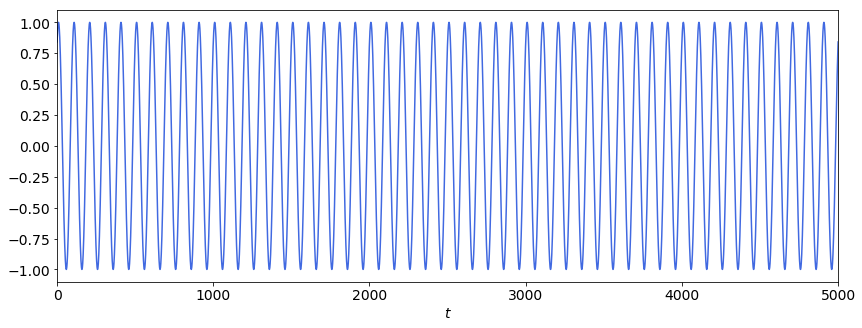

In [0]:
print("Total length: {}".format(len(data)))
print()
fig = plt.figure(figsize=(14, 5))
plt.plot(data, color="royalblue");
plt.xlim((0, 5001))
plt.xlabel("$t$")

adjust_fontsize(fig.axes)


We first divide the raw dataset into 4950 series with seq_len of 51 (with overlaps). 

In [0]:
# Prepare data.
seq_len = 50 + 1
sequences = torch.FloatTensor([data[t:t+seq_len] for t in range(len(data)-seq_len)])

print('Dimensions: {} x {}'.format(*sequences.shape))

Dimensions: 4950 x 51



We then separate the dataset in two parts, i.e. train and test datasets.

In [0]:
split_row = round(0.90*sequences.size(0))
x_train = sequences[:split_row, :-1]
y_train = sequences[:split_row, -1]
x_test = sequences[split_row:, :-1]
y_test = sequences[split_row:, -1]

print('x train: {} x {}'.format(*x_train.size()))
print('y train: {} x 1'.format(y_train.size(0)))
print(' x test: {} x {}'.format(*x_test.size()))
print(' y test: {} x 1'.format(y_test.size(0)))

x train: 4455 x 50
y train: 4455 x 1
 x test: 495 x 50
 y test: 495 x 1


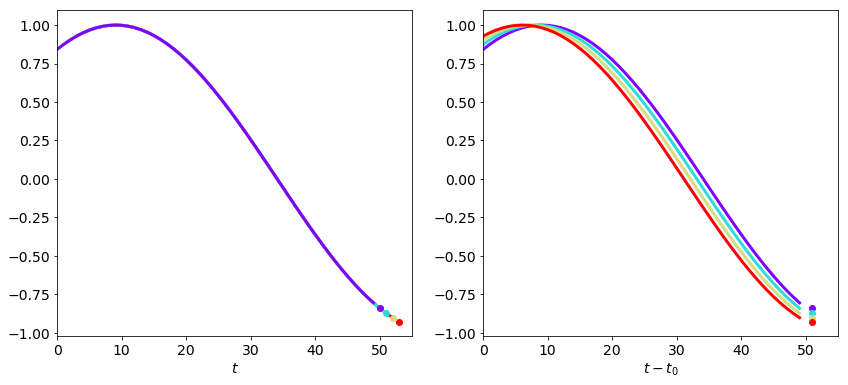

In [0]:
# Plot the first 4 sequences.
color = cm.rainbow(np.linspace(0, 1, 4))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for i in [3, 2, 1, 0]:
    ax1.plot(np.arange(50)+i, x_train[i].data.numpy(), linewidth=3, color=color[i]);
    ax1.plot(50+i, y_train[i].data.numpy(), 'o', color=color[i]);
    ax1.set_xlim(0, 55)
    ax1.set_xlabel('$t$')
    
for i in range(4):
    ax2.plot(np.arange(50), x_train[i].data.numpy(), linewidth=3, color=color[i]);
    ax2.plot(51, y_train[i].data.numpy(), 'o', color=color[i]);
    ax2.set_xlim(0, 55)
    ax2.set_xlabel('$t-t_0$')
    
adjust_fontsize([ax1, ax2])

Let's prepare an input data with a `batch_size` of 4, `seq_len` of 50 and `input_size` of 1.

The  input data format has to be  (seq_len, batch_size, input_size). 

In [0]:
# Select a minibatch of 4. 
x = x_train[:4, :, None]
y = y_train[:4]
print('x - original dimension: {} x {} x {}'.format(*x.shape))

# Reshape the tensor in the needed format (seq_len, batch_size, input_size).
x = x.permute(1, 0, 2)
print('x - new dimension: {} x {} x {}'.format(*x.shape))

x - original dimension: 4 x 50 x 1
x - new dimension: 50 x 4 x 1


__Q1__ : Given the example above, what are the data input parameters? 

* batch_size = 
* seq_len = 
* input = 


In [0]:
print('batch_size: {}'.format(x.shape[1]))
print('seq_len: {}'.format(x.shape[0]))
print('input_size: {}'.format(x.shape[2]))

batch_size: 4
seq_len: 50
input_size: 1


__Q2__  : Give an example where the `input_size` is superior to one, i.e. `input_size` $>1$.



![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.006.jpeg)


Fig.6 : Example with `input_size` $>1$.

### Create LSTM layer 

__Q3__  : Creat an LSTM layer. See Fig.3 above. This [example](https://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM) might be useful. 

Take the time to understand the dimension of the outputs. See Fig.5 for more information. 

In [0]:
# Q3
# Parameters. 
input_size = 1
hidden_size = 12
num_layers = 1

# LSTM layer.
lstm = nn.LSTM(input_size, hidden_size, num_layers)

# Forward pass.
output_0, (hn, cn) = lstm(x)

print('Dimension - output_0: {}'.format(output_0.shape))
print('Dimension - hn: {}'.format(hn.shape))
print('Dimension - cn: {}'.format(cn.shape))

Dimension - output_0: torch.Size([50, 4, 12])
Dimension - hn: torch.Size([1, 4, 12])
Dimension - cn: torch.Size([1, 4, 12])


### Reorganize the dimensions of `output_0`

Only the last component of the `output_0` tensor will be considered to make the prediction (See Fig.2).

For example, let's consider the 3rd sequence and its associated target. 

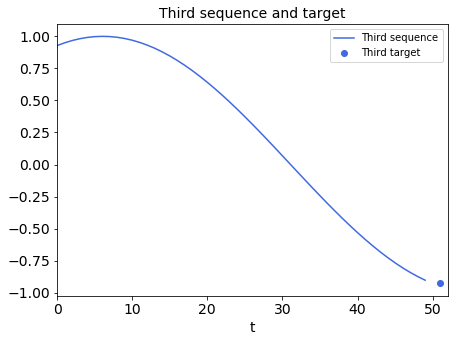

In [0]:
fig = plt.figure(figsize=(7, 5))
# Third sequence.
plt.plot(np.arange(50), x[:, 3, 0].data.numpy(), color="royalblue");
# Third target.
plt.plot(51, y[3].data.numpy(), 'o',  color="royalblue");

adjust_fontsize(fig.axes)
plt.xlim(0, 52)
plt.xlabel('t')
plt.legend(('Third sequence', 'Third target'))
plt.title('Third sequence and target')

adjust_fontsize(fig.axes)
plt.show()

The last component of  `output_0` is given by:

In [0]:
print(output_0[-1, 3, :])

tensor([-0.0980, -0.1521, -0.0242, -0.0955, -0.1054, -0.0950,  0.2697,  0.2108,
         0.0987,  0.0520, -0.1845,  0.1966], grad_fn=<SliceBackward>)


Note that the tensor `hn` contains the last hidden state of  each sequence for each layer. In principle, we could also use `hn` instead of `output_0`.

In [0]:
print(hn[-1, 3, :])

tensor([-0.0980, -0.1521, -0.0242, -0.0955, -0.1054, -0.0950,  0.2697,  0.2108,
         0.0987,  0.0520, -0.1845,  0.1966], grad_fn=<SliceBackward>)


__Q4__  : Propose a strategy to transform the tensor `output_0` of dimension $\left[50, 4, 12\right]$ to a tensor of dimension $\left[ 4, 1\right]$, i.e. same dimension as the targets. Specifically, what mathematical operation should be used to complete this task? 

Answer : Matrix product between `output_0` and a matrix $\mathbf{M}$. In this case, the dimension of $\mathbf{M}$ is `hidden_size` $\times 1$. 

\begin{align}
\text{output} =  \text{output_0}\;  \mathbf{M}
\end{align}

*  You can use the function `torch.matmul()`. You need to generate a random tensor with the proper dimension that multiplies `output_0`. See the documentation of:  [torch.Tensor(.)](https://pytorch.org/docs/master/tensors.html#torch.Tensor) and [torch.matmul(.)](https://pytorch.org/docs/master/torch.html?highlight=matmul#torch.matmul).


* You can also use a linear layer  `nn.Linear()` matching the dimension of $\mathbf{M}$. See the documentation of [nn.Linear(.)](https://pytorch.org/docs/master/nn.html#linear).



In [0]:
# With torch.Tensor() and torch.matmul(). 
M = torch.Tensor(hidden_size, input_size)
output = torch.matmul(output_0[-1, :, :], M)

print('First technique: {} x {}'.format(*output.shape))

# With nn.Linear().
LL = nn.Linear(hidden_size, input_size)
output = LL(output_0[-1, :, :])

print('Second technique: {} x {}'.format(*output.shape))

First technique: 4 x 1
Second technique: 4 x 1


## Our first LSTM

### The model class

__Q5__  : Read through the class LSTM() and complete the function LSTM.forward().





In [0]:
class LSTM(nn.Module):    
    def __init__(self, input_size, hidden_size, 
                 num_layers=1, dropout=0, bidirectional=False):
        """
        Args:
          input_size: number of features in the input of the LSTM.
          hidden_size: number of features in the hidden state.
          num_layers: number of recurrent layers (default: 1).
          dropout: if non-zero, introduces a Dropout layer on the outputs of each
                   LSTM layer except the last layer, with dropout probability equal
                   to dropout (default: 0).
          bidirectional: if True, becomes a bidirectional LSTM (default: False).
        """
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, inputs, hidden):
        """
        Args:
          inputs: tensor containing the features of the input sequence, (seq_len, batch_size, input_size).
          hidden: previous hidden state and cell state for each element in the batch,
                  ((num_layers*num_directions, batch_size, hidden_size),
                   (num_layers*num_directions, batch_size, hidden_size)).
                   
        Returns:
          predictions: one-step ahead predictions, (batch_size, 1).
          outputs: output features h_t of the last layer of the LSTM, (seq_len, batch_size, hidden_size).
          hidden: hidden state h_t and cell state c_t for t=1,
                  ((num_layers*num_directions, batch_size, hidden_size),
                   (num_layers*num_directions, batch_size, hidden_size)).
        """
        
        # Q5: use self.lstm and self.linear with the inputs and hidden arguments.
        outputs, hidden = self.lstm(inputs, hidden)
        predictions = self.linear(outputs[-1])
        return predictions.squeeze(1), outputs, hidden
    
    def init_hidden(self, batch_size):
        """Initializes the hidden state and cell state of the LSTM to default zero values.
        
        Args:
          batch_size: batch size at each time step.
          
        Returns:
          hidden: hidden state h_t and cell state c_t at t=0, 
                  ((num_layers*num_directions, batch_size, hidden_size),
                   (num_layers*num_directions, batch_size, hidden_size)).
        """
        num_directions = 2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        
        return hidden
    
    
def get_batch(x, y, i, batch_size):
    """Generate batch data for x and y."""
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

### Model training

__Q6__: Complete the training loop below. 

__Q7__: Train the model over 3 and 15 epochs and run the following forecasting cells. You may also test `hidden_size` equals to 1 and 24. Try with a `learning_rate` set to 0.02.

In [0]:
# Build model.
input_size = 1
hidden_size = 24 #1
num_layers = 1
lstm = LSTM(input_size, hidden_size, num_layers)

# Optimizer and loss function.
learning_rate = 0.0002 #0.02
max_grad_norm = 5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

# Train model.
batch_size = 12
num_epochs = 15 #3
num_sequences = x_train.size(0)
num_batches = num_sequences // batch_size
print("Training model for {} epoch of {} batches".format(num_epochs, num_batches))
for epoch in range(num_epochs):
    total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train.size(0))
    x = x_train[idx]
    y = y_train[idx]

    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train, y_train, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x, hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred, batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))

Training model for 15 epoch of 371 batches
Epoch 1: Loss = 0.30063766
Epoch 2: Loss = 0.04829900
Epoch 3: Loss = 0.01359826
Epoch 4: Loss = 0.00517680
Epoch 5: Loss = 0.00191441
Epoch 6: Loss = 0.00064613
Epoch 7: Loss = 0.00029287
Epoch 8: Loss = 0.00018916
Epoch 9: Loss = 0.00013849
Epoch 10: Loss = 0.00010337
Epoch 11: Loss = 0.00007714
Epoch 12: Loss = 0.00005723
Epoch 13: Loss = 0.00004202
Epoch 14: Loss = 0.00003043
Epoch 15: Loss = 0.00002174


__Q9__ : Read carefully the `predict_one_step()` function below. Explain to your partner the operations in the for loop.

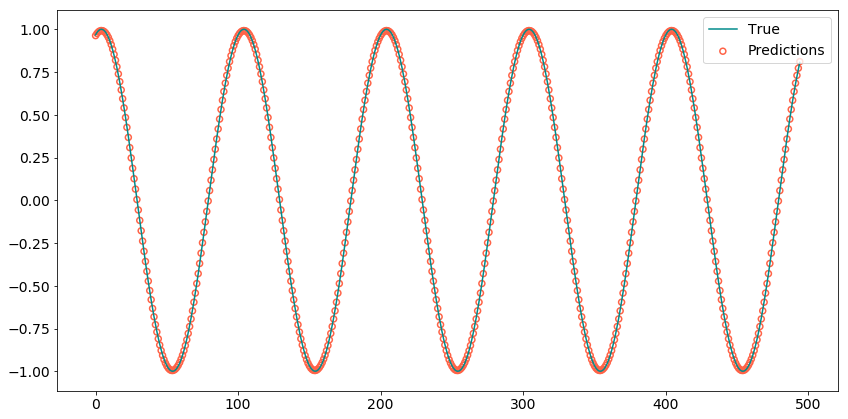

In [0]:
def predict_one_step(model, data, input_size, num_steps):
    """Predicts one-step ahead for each sequence of the test set."""
    
    predictions = torch.zeros(num_steps)
    for i, x in enumerate(data):
        hidden = model.init_hidden(1)
        y_pred, _, _ = model(x.contiguous().view(-1, 1, input_size), hidden)
        predictions[i] = y_pred
    return predictions
 

one_step_predictions = predict_one_step(lstm, x_test, input_size, y_test.size(0))

fig = plt.figure(figsize=(14, 7))
plt.plot(y_test.data.numpy(), color="darkcyan", label="True")
plt.scatter(range(0, y_test.size(0)), one_step_predictions.data.numpy(), facecolors="none",
            edgecolors="tomato", linewidths=1.5, label="Predictions")
plt.legend(loc="upper right", fontsize=14)
adjust_fontsize(fig.axes)

plt.show()

__Q10__ : Read carefully the `predict_full_sequence()` function below. Explain to your partner the operations in the for loop. 

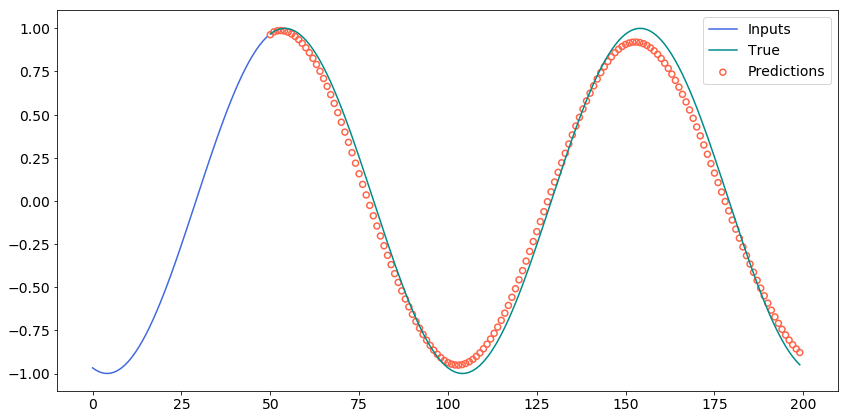

In [0]:
def predict_full_sequence(model, x, input_size, num_steps):
    """Predicts one-step ahead with a single sequence from the test set
       and use predictions to predict the remaining test set sequence
       for num_steps.
    """
    predictions = torch.zeros(num_steps)
    hidden = model.init_hidden(1)
    y_pred, _, hidden = model(x.contiguous().view(-1, 1, input_size), hidden)
    x = torch.cat((x, y_pred))
    predictions[0] = y_pred
    for i in range(1, num_steps):
        y_pred, _, hidden = model(x.contiguous().view(-1, 1, input_size), hidden)
        x = torch.cat((x, y_pred))
        predictions[i] = y_pred
    return predictions


x = torch.FloatTensor(x_test[0])
num_steps = 150  # Do not set to higher value due to memory constraint
full_predictions = predict_full_sequence(lstm, x, input_size, num_steps)
fig = plt.figure(figsize=(14, 7))
plt.plot(range(0, x.size(0)), x.data.numpy(), color="royalblue", label="Inputs")
plt.plot(range(x.size(0), x.size(0)+num_steps), y_test[:num_steps].data.numpy(), color="darkcyan", label="True")
plt.scatter(range(x.size(0), x.size(0)+num_steps), full_predictions.data.numpy(),
            facecolors="none", edgecolors="tomato", linewidths=1.5, label="Predictions")
plt.legend(loc="upper right", fontsize=14)
adjust_fontsize(fig.axes)

plt.show()